Importing Libraries

In [91]:
import emoji
import string
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 
from nltk.corpus import stopwords
%matplotlib inline
stop = stopwords.words('english')
warnings.filterwarnings('ignore')
lemmatizer = WordNetLemmatizer()

Reading and Processing The Data

In [92]:
video_df = pd.read_csv("kaggle/input/youtube-statistics/videos-stats.csv")
comm_df = pd.read_csv("kaggle/input/youtube-statistics/comments.csv")

# Drop Unnamed: 0 column
video_df = video_df.drop(columns=["Unnamed: 0"])
comm_df = comm_df.drop(columns=["Unnamed: 0"])

# Drop nan values
video_df = video_df.dropna()
comm_df = comm_df.dropna()

# Drop duplicates
video_df.drop_duplicates(keep='first', inplace=True)
comm_df.drop_duplicates(keep='first', inplace=True)

# Cast columns to int
video_df["Likes"] = video_df["Likes"].astype(int)
video_df["Comments"] = video_df["Comments"].astype(int)
video_df["Views"] = video_df["Views"].astype(int)
comm_df["Likes"] = comm_df["Likes"].astype(int)
comm_df["Sentiment"] = comm_df["Sentiment"].astype(int)



In [93]:
comm_df

,Video ID,Comment,Likes,Sentiment
0,wAZZ-UWGVHI,Let's not forget that Apple Pay in 2014 requir...,95,1
1,wAZZ-UWGVHI,Here in NZ 50% of retailers don’t even have co...,19,0
2,wAZZ-UWGVHI,I will forever acknowledge this channel with t...,161,2
3,wAZZ-UWGVHI,Whenever I go to a place that doesn’t take App...,8,0
4,wAZZ-UWGVHI,"Apple Pay is so convenient, secure, and easy t...",34,2
...,...,...,...,...
18404,cyLWtMSry58,I really like the point about engineering tool...,0,2
18405,cyLWtMSry58,I’ve just started exploring this field. And th...,20,2
18406,cyLWtMSry58,Excelente video con una pregunta filosófica pr...,1,1
18407,cyLWtMSry58,"Hey Daniel, just discovered your channel a cou...",35,2


In [94]:
comm_df = comm_df.replace(to_replace=[0,1,2], value=[-1,0,1])

In [95]:
comm_df

,Video ID,Comment,Likes,Sentiment
0,wAZZ-UWGVHI,Let's not forget that Apple Pay in 2014 requir...,95,0
1,wAZZ-UWGVHI,Here in NZ 50% of retailers don’t even have co...,19,-1
2,wAZZ-UWGVHI,I will forever acknowledge this channel with t...,161,1
3,wAZZ-UWGVHI,Whenever I go to a place that doesn’t take App...,8,-1
4,wAZZ-UWGVHI,"Apple Pay is so convenient, secure, and easy t...",34,1
...,...,...,...,...
18404,cyLWtMSry58,I really like the point about engineering tool...,-1,1
18405,cyLWtMSry58,I’ve just started exploring this field. And th...,20,1
18406,cyLWtMSry58,Excelente video con una pregunta filosófica pr...,0,0
18407,cyLWtMSry58,"Hey Daniel, just discovered your channel a cou...",35,1


In [96]:
def clean_text(text):
       
    # Remove \r and \n
    text = text.replace('\r', '').replace('\n', ' ')

    # Remove emojis
    text = emoji.demojize(text)

    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Convert to lowercase and remove non-alphabetic tokens
    tokens = [t.lower() for t in tokens if t.isalpha()]
    
    # Remove stop words and punctuation, and lemmatize
    stop_words = stopwords.words('english')
    punctuation = list(string.punctuation)
    tokens_to_remove = stop_words + punctuation
    lemma = WordNetLemmatizer()
    tokens = [lemma.lemmatize(t) for t in tokens if t not in tokens_to_remove]

    return ' '.join(tokens)

def preprocess_df(df):
    # Clean the comments
    df['Comment_cleaned'] = df['Comment'].apply(clean_text)

    # Add comment lengths
    df['Comment Length'] = df['Comment_cleaned'].apply(lambda x: len(str(x).split()))

    # Removing empty comments
    new_df = df[df['Comment Length'] > 0]

    # Remove outliers
    new_df = new_df[new_df['Comment Length'] <= 50]
    
    return new_df

In [97]:
new_comm_df = preprocess_df(comm_df)
max_seq_len = 50

# Define features and target columns
X = new_comm_df['Comment_cleaned']
y = np.array(new_comm_df['Sentiment'])

In [98]:
new_comm_df

,Video ID,Comment,Likes,Sentiment,Comment_cleaned,Comment Length
0,wAZZ-UWGVHI,Let's not forget that Apple Pay in 2014 requir...,95,0,let forget apple pay required brand new iphone...,32
1,wAZZ-UWGVHI,Here in NZ 50% of retailers don’t even have co...,19,-1,nz retailer even contactless credit card machi...,15
2,wAZZ-UWGVHI,I will forever acknowledge this channel with t...,161,1,forever acknowledge channel help lesson idea e...,14
3,wAZZ-UWGVHI,Whenever I go to a place that doesn’t take App...,8,-1,whenever go place take apple pay happen often ...,42
4,wAZZ-UWGVHI,"Apple Pay is so convenient, secure, and easy t...",34,1,apple pay convenient secure easy use used kore...,14
...,...,...,...,...,...,...
18404,cyLWtMSry58,I really like the point about engineering tool...,-1,1,really like point engineering toolbox think lo...,30
18405,cyLWtMSry58,I’ve just started exploring this field. And th...,20,1,started exploring field really good reminder g...,11
18406,cyLWtMSry58,Excelente video con una pregunta filosófica pr...,0,0,excelente video con una pregunta filosófica pr...,39
18407,cyLWtMSry58,"Hey Daniel, just discovered your channel a cou...",35,1,hey daniel discovered channel couple day ago l...,10


In [99]:
# Functions to plot confusion matrix and calculate accuracy

def plot_conf_matrix(y_test, y_pred):
    
    cm = confusion_matrix(y_test, y_pred)
    cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
    
    cmdisp.plot()
    plt.show()
    
def calculate_acc(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred.round())
    print('Accuracy:', accuracy)

### Vectorizing and Transforming TF-IDF

In [100]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X).toarray()

In [101]:
tfidfconverter = TfidfTransformer()  
X = tfidfconverter.fit_transform(X)  

Train-Test Split

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=24, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=24, stratify=y_train)

### Initializing & Evaluating the Multinomial Naive-Bayes Model

In [103]:
NB=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
NB.fit(X_train, y_train)
y_pred=NB.predict(X_test)

In [104]:
print(f"Accuracy score: {(accuracy_score(y_test,y_pred) * 100):.2f}%")

Accuracy score: 66.63%


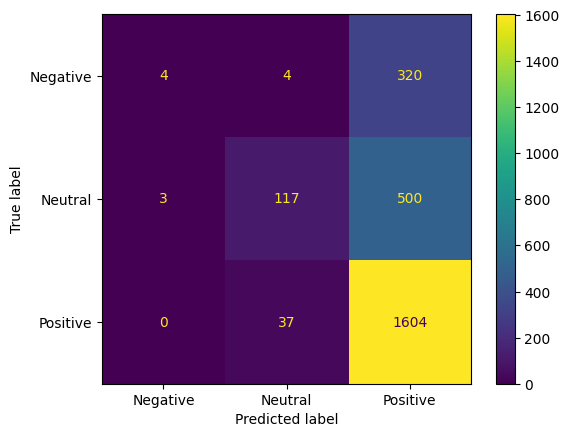

In [105]:
plot_conf_matrix(y_test, y_pred)

In [106]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.57      0.01      0.02       328
           0       0.74      0.19      0.30       620
           1       0.66      0.98      0.79      1641

    accuracy                           0.67      2589
   macro avg       0.66      0.39      0.37      2589
weighted avg       0.67      0.67      0.58      2589



### Hyperparameter Tuning with GridSearchCV

In [107]:
NB = MultinomialNB(class_prior=None, fit_prior=True)

# Define hyperparameter grid
param_grid = {'alpha': [0.0001, 0.001, 0.005, 0.1, 0.15, 0.2, 0.5, 1.0, 1.5, 2.0]}

# Instantiate GridSearchCV
grid_search = GridSearchCV(NB, param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters:", grid_search.best_params_)

# Get best model
best_model = grid_search.best_estimator_

# Predict on test data
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {(accuracy_score(y_test,y_pred) * 100):.2f}%")


Best parameters: {'alpha': 0.1}
Accuracy score: 72.07%


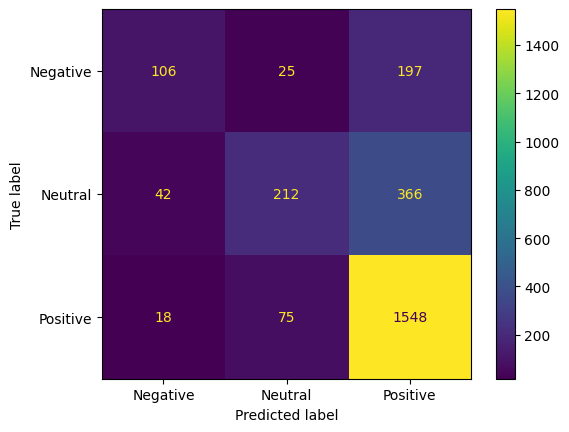

In [108]:
plot_conf_matrix(y_test, y_pred)

In [109]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.64      0.32      0.43       328
           0       0.68      0.34      0.45       620
           1       0.73      0.94      0.83      1641

    accuracy                           0.72      2589
   macro avg       0.68      0.54      0.57      2589
weighted avg       0.71      0.72      0.69      2589



## ***Results***

### Before Tuning *(Alpha = 1, default)*

 ***Accuracy:*** **67%** overall accuracy, indicating a reasonable starting point.

 ***Class-Specific Performance:***

   **-1** ***(Negative)***: Very poor recall *(1%)*, meaning it misses most of the negative comments. Low precision *(57%)* suggests many misclassifications as negative.

   **0** ***(Neutral)***: Low recall *(19%)* and moderate precision *(74%)*, indicating difficulties identifying neutral sentiment.

   **1** ***(Positive)***: High recall *(98%)*, correctly identifying most positive comments as the majority of dataset is positive, but with lower precision *(66%)*, suggesting some misclassifications as positive.




### After Tuning *(Alpha = 0.1)*

***Accuracy:*** Improved to **72%**, a noticeable gain.

***Class-Specific Performance:***

**-1** ***(Negative)***: Recall increased significantly *(32%)*, meaning the model now captures more negative comments as it can be seen on confusion matrices. Precision also improved *(64%)*, reducing false positives.

**0** ***(Neutral)***: Recall increased slightly *(34%)*, still a challenge but a step forward. Precision improved slightly *(68%)*.

**1** ***(Positive)***: Recall remains high *(94%)*, but precision improved *(73%)*, indicating better accuracy in classifying positive comments while decreasing model's tend to predicting as positive for every data.